In [ ]:
### This script carries out a fitting of the various Glazer tilt systems to measured data on a perovskite. 
### It takes in a 2x2x2 40-atom supercell of the perovskite with P1 symmetry.

### Glazer fitting of temperature series

In [4]:
%load_ext autoreload
%autoreload 2

# Import packages that we will need.
import os
import sys
import yaml
import collections

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams.update(mpl.rcParamsDefault)
stylesheet = '<path to style sheet>'
plt.style.use(stylesheet)

from diffpy.srfit.fitbase import FitContribution, FitRecipe, FitResults, Profile, FitHook
from diffpy.srfit.fitbase.fitresults import initializeRecipe
from diffpy.srfit.structure import constrainAsSpaceGroup
from diffpy.srfit.pdf import PDFParser, PDFGenerator
from diffpy.structure import Structure
from scipy.optimize import least_squares

import numpy as np
from sympy import *
np.seterr(invalid='ignore')

%matplotlib inline

In [5]:
# Import Glazer functions from glazer_functions.py and the global parameters from global_par.py
import glazer_functions as gf
import global_par as gl

param = gl.shared.config        # call within module using global variable

In [6]:
gl.shared.config = {}
param = gl.shared.config
print(param)

{}


In [7]:
### PARAMETERS NOT TO BE REFINED

# Give the elements in the perovskite
element_a = "Nd" # A cation
element_b = "Ni" # B cation
element_x = "O"  # X anions
compound = "{}{}{}3".format(element_a, element_b, element_x)

qmin = 0  # qmin in Fourier transform
qmax = 24 # qmax in Fourier transform

qdamp = 0.0255496541373  # qdamp from calibration
qbroad = 0.0220472479685  # qbroad from calibration

rmin = 1.6  # Minimum fitting range of r
rmax = 10  # Maximum fitting range of r
rstep = 0.01

RUN_PARALLEL = True

In [8]:
### REFINABLE VARIABLES

######## GLAZER SYSTEM ID ################################
glazer_system = 10  #choice of glazer system

######## START VALUES TO BE REFINED ######################
# initial cubic lattice parameter
latpar_a_cub_i =  3.80
# initial tilt amplitudes (absolute values) around the three crystallagraphic axes
glazer_tilts = {'alpha_i': 9, 'beta_i': 7.5, 'gamma_i': 7.5}
# initial A cation displacements along the relevant crystallographic axes
adisp = {'aydisp_i': 0.0175, 'azdisp_i': 0.0175}

uiso_a_i = 0.005  # initial value for isotropic Uiso(A)
uiso_b_i = 0.002  # initial value for isotropic Uiso(B)
uiso_x_i = 0.007  # initial value for isotropic Uiso(X)

delta2_i = 1.0  # initial value for nearest neighbor correlation
scale_i = 1  # initial value for scale

In [12]:
############### LOADING Data and models ##############################
dpath = '<path to directory containing gr temperature series>'
gr_name = '<path to single gr file for testing>'
mpath = "models"
cif_name = "NdNiO3_2x2x2-supercell_0_0_0_tilt.cif"

In [13]:
def load_pdfs_from_dir(dpath):
	"""Loads PDFs from directory and puts into dictionary
	Reads the columns for r and g(r) in the .gr files in 
	a directory and stores in a dictionary with keys for
	all the different temperatures

	Parameters
	----------
	dpath : path
	    folder containing the pdfs

	Returns
	----------
	gr :   dict, 
	   contains the r and g(r) for all the temperatures
	"""

	# Script will read filenames that look like this: NOM_9999_NdNiO3_100.0K_24_ftfrgr.gr
	
	gr = {}
	gr_paths = {}
	temps = []
	files = [file for file in os.listdir(dpath) if file.split('_')[-1] in ['ftfrgr.gr'] and file.split('_')[4] in [str(qmax)]]
	for file in files:
		temp = round(float((file.split('_')[3]).split('K')[0]))
		temps.append(temp)
		gr_paths[temp] = os.path.join(dpath,file)
		with open(gr_paths[temp]) as filehandle:
			lines = list(filehandle.readlines()[26:])
			gr[temp] = np.empty((2, len(lines)))
			for line in lines:
				i = lines.index(line)
				gr[temp][0][i] = lines[i].split()[0]
				gr[temp][1][i] = lines[i].split()[1]

	print('Loaded pdfs for temperatures {}'.format(list(gr.keys())))

	return(gr, gr_paths, temps)

gr, gr_paths, temps_selected = load_pdfs_from_dir(dpath)
print(gr_paths)

Loaded pdfs for temperatures [100, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 300]
{100: '../../data/2014_03_neutron_sns-nomad-mikhail/grfiles/MT300/NOM_9999_NdNiO3_100.0K_24_ftfrgr.gr', 150: '../../data/2014_03_neutron_sns-nomad-mikhail/grfiles/MT300/NOM_9999_NdNiO3_150.0K_24_ftfrgr.gr', 160: '../../data/2014_03_neutron_sns-nomad-mikhail/grfiles/MT300/NOM_9999_NdNiO3_160.0K_24_ftfrgr.gr', 170: '../../data/2014_03_neutron_sns-nomad-mikhail/grfiles/MT300/NOM_9999_NdNiO3_170.0K_24_ftfrgr.gr', 180: '../../data/2014_03_neutron_sns-nomad-mikhail/grfiles/MT300/NOM_9999_NdNiO3_180.0K_24_ftfrgr.gr', 190: '../../data/2014_03_neutron_sns-nomad-mikhail/grfiles/MT300/NOM_9999_NdNiO3_190.0K_24_ftfrgr.gr', 200: '../../data/2014_03_neutron_sns-nomad-mikhail/grfiles/MT300/NOM_9999_NdNiO3_200.0K_24_ftfrgr.gr', 210: '../../data/2014_03_neutron_sns-nomad-mikhail/grfiles/MT300/NOM_9999_NdNiO3_210.0K_24_ftfrgr.gr', 220: '../../data/2014_03_neutron_sns-nomad-mikhail/grfiles/MT300/NOM_9999_NdNiO3

In [14]:
dict={}
dict["element_a"] = element_a
dict["element_b"] = element_b
dict["element_x"] = element_x
dict["compound"] = compound
dict["qmax"] = qmax
dict["qmin"] = qmin
dict["qdamp"] = qdamp
dict["qbroad"] = qbroad
dict["rmin"] = rmin
dict["rmax"] = rmax
dict["rstep"] = rstep
dict["RUN_PARALLEL"] = RUN_PARALLEL

dict["glazer_system"] = glazer_system
dict["latpar_a_cub_i"] = latpar_a_cub_i
dict["glazer_tilts"] = glazer_tilts
dict["adisp"] = adisp
dict["uiso_a_i"] = uiso_a_i
dict["uiso_b_i"] = uiso_b_i
dict["uiso_x_i"] = uiso_x_i
dict["delta2_i"] = delta2_i
dict["scale_i"] = scale_i

dict["dpath"] = dpath
dict["gr_name"] = gr_name
dict["gr_paths"] = gr_paths
dict["mpath"] = mpath
dict["cif_name"] = cif_name
dict["temps_selected"] = temps_selected

gl.shared.config = dict
param = gl.shared.config

Setting up constraints and variables for the A cations in Glazer system 10.
Refinement will start with values [0.0175, 0.0175].

This Glazer system has two tilt degrees of freedom. 
Please make sure you have set alpha_i and beta_i.
Refinement will start with values [9, -7.5, -7.5]. 
Positive values signify in-phase tilt, negative values signify out-of-phase tilt.

Setting up constraints for the oxygens using the Glazer tilt variables.

Setting up constraints for the lattice parameters using the Glazer tilt variables.

Starting refinement NdNiO3_300.0K_24_GS_10_r_1.6-10...
Optimizing scale...
Optimizing lattice parameter and Glazer tilts...
Optimizing A site displacements...
Optimizing Glazer tilts and A site displacements together...
Optimizing ADPs...
Optimizing scale, lattice parameter, Glazer tilts and A site displacements together...
... and adding in the ADPs...
Optimizing scale, lattice parameter and Glazer tilts once more...
Optimizing delta...
Optimizing all parameters together

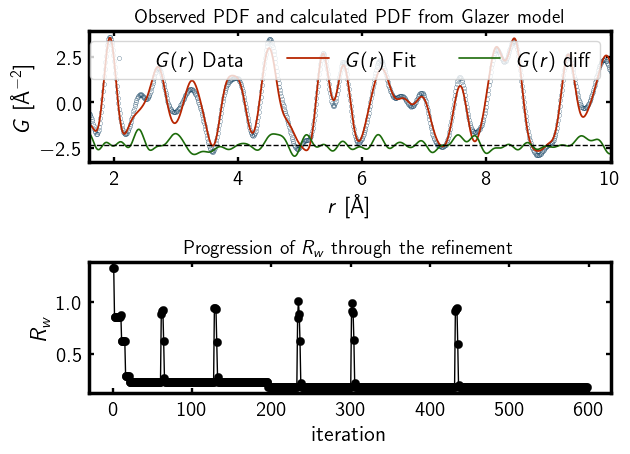

In [15]:
# Single fit
if __name__ == "__main__":
    gf.main()

Setting up constraints and variables for the A cations in Glazer system 10.
Refinement will start with values [0.0175, 0.0175].

This Glazer system has two tilt degrees of freedom. 
Please make sure you have set alpha_i and beta_i.
Refinement will start with values [9, -7.5, -7.5]. 
Positive values signify in-phase tilt, negative values signify out-of-phase tilt.

Setting up constraints for the oxygens using the Glazer tilt variables.

Setting up constraints for the lattice parameters using the Glazer tilt variables.

####################### Starting refinement for NdNiO3_GS_10_r_1.6-10_T_100 #######################
Optimizing scale...
Optimizing lattice parameter and Glazer tilts...
Optimizing A site displacements...
Optimizing Glazer tilts and A site displacements together...
Optimizing ADPs...
Optimizing scale, lattice parameter, Glazer tilts and A site displacements together...
... and adding in the ADPs...
Optimizing scale, lattice parameter and Glazer tilts once more...
Optimizin

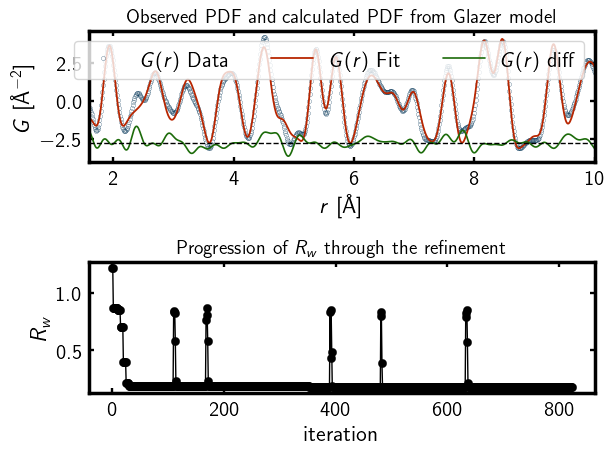

Dumped output_glazer/NdNiO3_GS_10_r_1.6-10_tempseries/NdNiO3_GS_10_r_1.6-10_tempseries_refined_params.yml
####################### Starting refinement for NdNiO3_GS_10_r_1.6-10_T_150 #######################
Optimizing scale...
Optimizing lattice parameter and Glazer tilts...
Optimizing A site displacements...
Optimizing Glazer tilts and A site displacements together...
Optimizing ADPs...
Optimizing scale, lattice parameter, Glazer tilts and A site displacements together...
... and adding in the ADPs...
Optimizing scale, lattice parameter and Glazer tilts once more...
Optimizing delta...
Optimizing all parameters together...
... done!

Dumped output_glazer/NdNiO3_GS_10_r_1.6-10_tempseries/fit/NdNiO3_GS_10_r_1.6-10_T_150.fit
Dumped output_glazer/NdNiO3_GS_10_r_1.6-10_tempseries/res/NdNiO3_GS_10_r_1.6-10_T_150.res
Dumped output_glazer/NdNiO3_GS_10_r_1.6-10_tempseries/stru//NdNiO3_GS_10_r_1.6-10_T_150.cif

Results from the Glazer fit:
Some quantities invalid due to missing profile uncertain

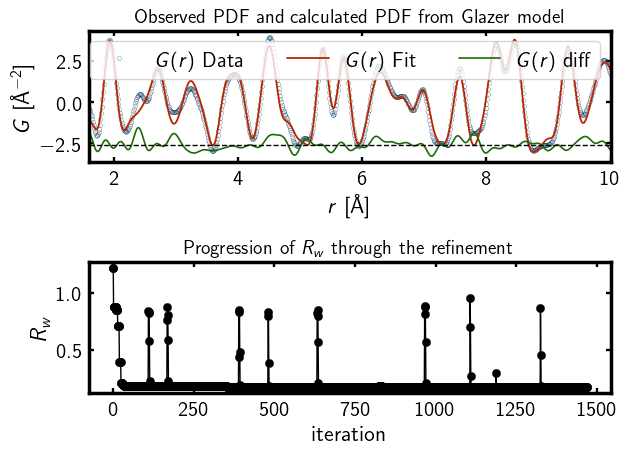

Dumped output_glazer/NdNiO3_GS_10_r_1.6-10_tempseries/NdNiO3_GS_10_r_1.6-10_tempseries_refined_params.yml
####################### Starting refinement for NdNiO3_GS_10_r_1.6-10_T_160 #######################
Optimizing scale...
Optimizing lattice parameter and Glazer tilts...
Optimizing A site displacements...
Optimizing Glazer tilts and A site displacements together...
Optimizing ADPs...
Optimizing scale, lattice parameter, Glazer tilts and A site displacements together...
... and adding in the ADPs...
Optimizing scale, lattice parameter and Glazer tilts once more...
Optimizing delta...
Optimizing all parameters together...
... done!

Dumped output_glazer/NdNiO3_GS_10_r_1.6-10_tempseries/fit/NdNiO3_GS_10_r_1.6-10_T_160.fit
Dumped output_glazer/NdNiO3_GS_10_r_1.6-10_tempseries/res/NdNiO3_GS_10_r_1.6-10_T_160.res
Dumped output_glazer/NdNiO3_GS_10_r_1.6-10_tempseries/stru//NdNiO3_GS_10_r_1.6-10_T_160.cif

Results from the Glazer fit:
Some quantities invalid due to missing profile uncertain

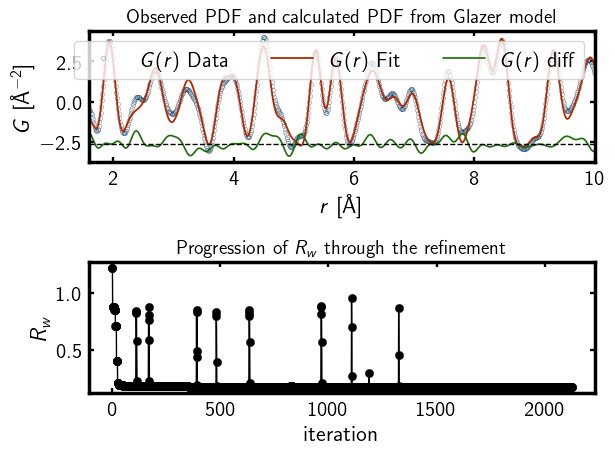

Dumped output_glazer/NdNiO3_GS_10_r_1.6-10_tempseries/NdNiO3_GS_10_r_1.6-10_tempseries_refined_params.yml
####################### Starting refinement for NdNiO3_GS_10_r_1.6-10_T_170 #######################
Optimizing scale...
Optimizing lattice parameter and Glazer tilts...
Optimizing A site displacements...
Optimizing Glazer tilts and A site displacements together...
Optimizing ADPs...
Optimizing scale, lattice parameter, Glazer tilts and A site displacements together...
... and adding in the ADPs...
Optimizing scale, lattice parameter and Glazer tilts once more...
Optimizing delta...
Optimizing all parameters together...
... done!

Dumped output_glazer/NdNiO3_GS_10_r_1.6-10_tempseries/fit/NdNiO3_GS_10_r_1.6-10_T_170.fit
Dumped output_glazer/NdNiO3_GS_10_r_1.6-10_tempseries/res/NdNiO3_GS_10_r_1.6-10_T_170.res
Dumped output_glazer/NdNiO3_GS_10_r_1.6-10_tempseries/stru//NdNiO3_GS_10_r_1.6-10_T_170.cif

Results from the Glazer fit:
Some quantities invalid due to missing profile uncertain

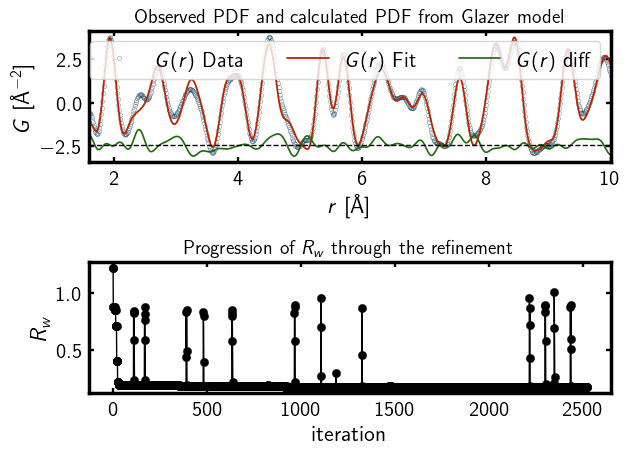

Dumped output_glazer/NdNiO3_GS_10_r_1.6-10_tempseries/NdNiO3_GS_10_r_1.6-10_tempseries_refined_params.yml
####################### Starting refinement for NdNiO3_GS_10_r_1.6-10_T_180 #######################
Optimizing scale...
Optimizing lattice parameter and Glazer tilts...
Optimizing A site displacements...
Optimizing Glazer tilts and A site displacements together...
Optimizing ADPs...
Optimizing scale, lattice parameter, Glazer tilts and A site displacements together...
... and adding in the ADPs...
Optimizing scale, lattice parameter and Glazer tilts once more...
Optimizing delta...
Optimizing all parameters together...
... done!

Dumped output_glazer/NdNiO3_GS_10_r_1.6-10_tempseries/fit/NdNiO3_GS_10_r_1.6-10_T_180.fit
Dumped output_glazer/NdNiO3_GS_10_r_1.6-10_tempseries/res/NdNiO3_GS_10_r_1.6-10_T_180.res
Dumped output_glazer/NdNiO3_GS_10_r_1.6-10_tempseries/stru//NdNiO3_GS_10_r_1.6-10_T_180.cif

Results from the Glazer fit:
Some quantities invalid due to missing profile uncertain

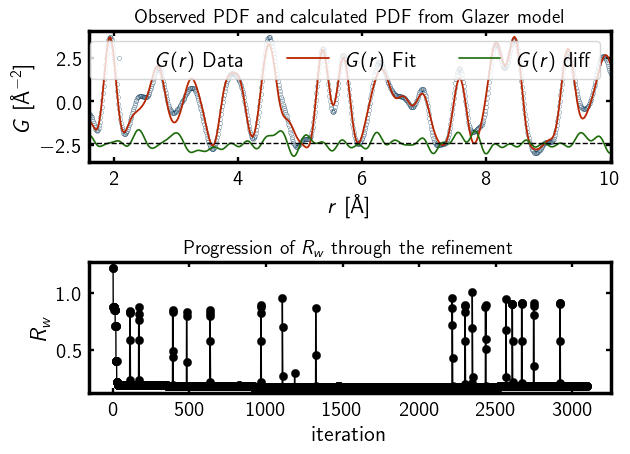

Dumped output_glazer/NdNiO3_GS_10_r_1.6-10_tempseries/NdNiO3_GS_10_r_1.6-10_tempseries_refined_params.yml
####################### Starting refinement for NdNiO3_GS_10_r_1.6-10_T_190 #######################
Optimizing scale...
Optimizing lattice parameter and Glazer tilts...
Optimizing A site displacements...
Optimizing Glazer tilts and A site displacements together...
Optimizing ADPs...
Optimizing scale, lattice parameter, Glazer tilts and A site displacements together...
... and adding in the ADPs...
Optimizing scale, lattice parameter and Glazer tilts once more...
Optimizing delta...
Optimizing all parameters together...
... done!

Dumped output_glazer/NdNiO3_GS_10_r_1.6-10_tempseries/fit/NdNiO3_GS_10_r_1.6-10_T_190.fit
Dumped output_glazer/NdNiO3_GS_10_r_1.6-10_tempseries/res/NdNiO3_GS_10_r_1.6-10_T_190.res
Dumped output_glazer/NdNiO3_GS_10_r_1.6-10_tempseries/stru//NdNiO3_GS_10_r_1.6-10_T_190.cif

Results from the Glazer fit:
Some quantities invalid due to missing profile uncertain

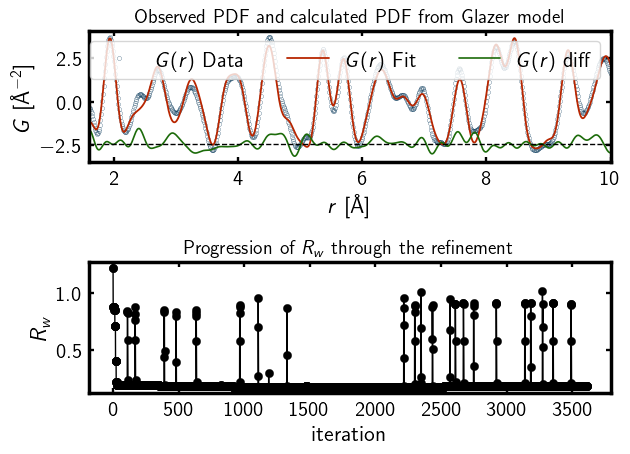

Dumped output_glazer/NdNiO3_GS_10_r_1.6-10_tempseries/NdNiO3_GS_10_r_1.6-10_tempseries_refined_params.yml
####################### Starting refinement for NdNiO3_GS_10_r_1.6-10_T_200 #######################
Optimizing scale...
Optimizing lattice parameter and Glazer tilts...
Optimizing A site displacements...
Optimizing Glazer tilts and A site displacements together...
Optimizing ADPs...
Optimizing scale, lattice parameter, Glazer tilts and A site displacements together...
... and adding in the ADPs...
Optimizing scale, lattice parameter and Glazer tilts once more...
Optimizing delta...
Optimizing all parameters together...
... done!

Dumped output_glazer/NdNiO3_GS_10_r_1.6-10_tempseries/fit/NdNiO3_GS_10_r_1.6-10_T_200.fit
Dumped output_glazer/NdNiO3_GS_10_r_1.6-10_tempseries/res/NdNiO3_GS_10_r_1.6-10_T_200.res
Dumped output_glazer/NdNiO3_GS_10_r_1.6-10_tempseries/stru//NdNiO3_GS_10_r_1.6-10_T_200.cif

Results from the Glazer fit:
Some quantities invalid due to missing profile uncertain

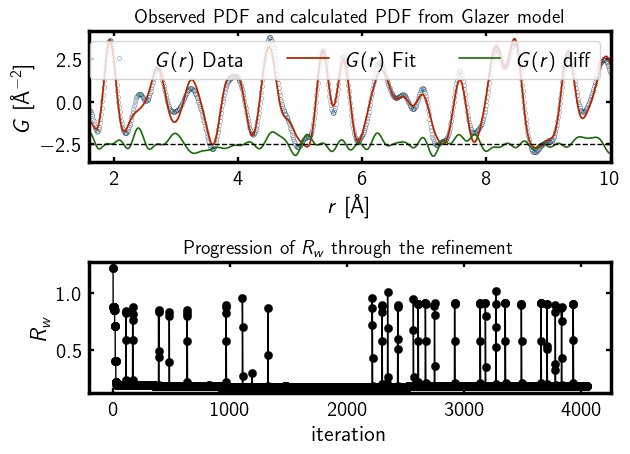

Dumped output_glazer/NdNiO3_GS_10_r_1.6-10_tempseries/NdNiO3_GS_10_r_1.6-10_tempseries_refined_params.yml
####################### Starting refinement for NdNiO3_GS_10_r_1.6-10_T_210 #######################
Optimizing scale...
Optimizing lattice parameter and Glazer tilts...
Optimizing A site displacements...
Optimizing Glazer tilts and A site displacements together...
Optimizing ADPs...
Optimizing scale, lattice parameter, Glazer tilts and A site displacements together...
... and adding in the ADPs...
Optimizing scale, lattice parameter and Glazer tilts once more...
Optimizing delta...
Optimizing all parameters together...
... done!

Dumped output_glazer/NdNiO3_GS_10_r_1.6-10_tempseries/fit/NdNiO3_GS_10_r_1.6-10_T_210.fit
Dumped output_glazer/NdNiO3_GS_10_r_1.6-10_tempseries/res/NdNiO3_GS_10_r_1.6-10_T_210.res
Dumped output_glazer/NdNiO3_GS_10_r_1.6-10_tempseries/stru//NdNiO3_GS_10_r_1.6-10_T_210.cif

Results from the Glazer fit:
Some quantities invalid due to missing profile uncertain

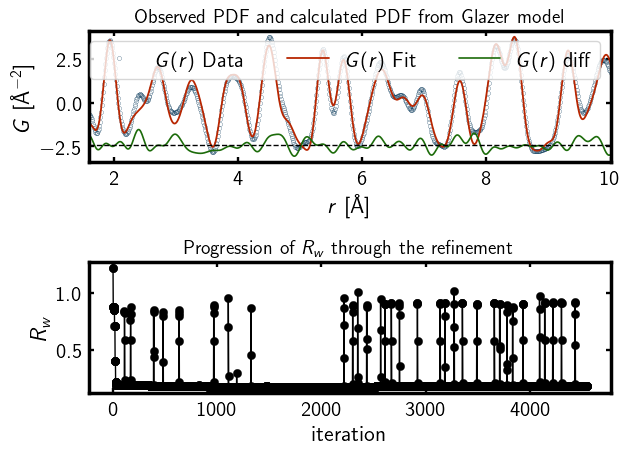

Dumped output_glazer/NdNiO3_GS_10_r_1.6-10_tempseries/NdNiO3_GS_10_r_1.6-10_tempseries_refined_params.yml
####################### Starting refinement for NdNiO3_GS_10_r_1.6-10_T_220 #######################
Optimizing scale...
Optimizing lattice parameter and Glazer tilts...
Optimizing A site displacements...
Optimizing Glazer tilts and A site displacements together...
Optimizing ADPs...
Optimizing scale, lattice parameter, Glazer tilts and A site displacements together...
... and adding in the ADPs...
Optimizing scale, lattice parameter and Glazer tilts once more...
Optimizing delta...
Optimizing all parameters together...
... done!

Dumped output_glazer/NdNiO3_GS_10_r_1.6-10_tempseries/fit/NdNiO3_GS_10_r_1.6-10_T_220.fit
Dumped output_glazer/NdNiO3_GS_10_r_1.6-10_tempseries/res/NdNiO3_GS_10_r_1.6-10_T_220.res
Dumped output_glazer/NdNiO3_GS_10_r_1.6-10_tempseries/stru//NdNiO3_GS_10_r_1.6-10_T_220.cif

Results from the Glazer fit:
Some quantities invalid due to missing profile uncertain

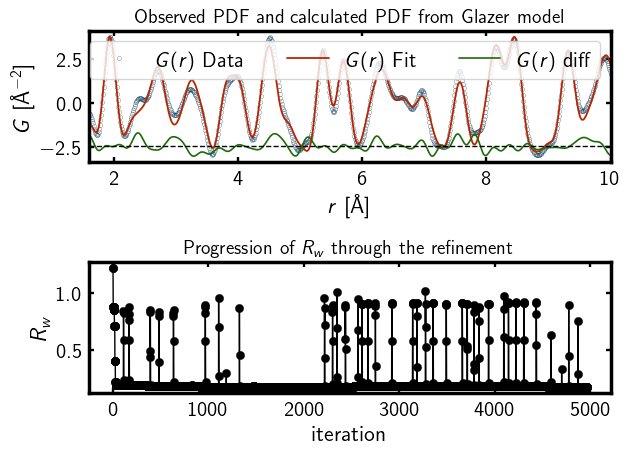

Dumped output_glazer/NdNiO3_GS_10_r_1.6-10_tempseries/NdNiO3_GS_10_r_1.6-10_tempseries_refined_params.yml
####################### Starting refinement for NdNiO3_GS_10_r_1.6-10_T_230 #######################
Optimizing scale...
Optimizing lattice parameter and Glazer tilts...
Optimizing A site displacements...
Optimizing Glazer tilts and A site displacements together...
Optimizing ADPs...
Optimizing scale, lattice parameter, Glazer tilts and A site displacements together...
... and adding in the ADPs...
Optimizing scale, lattice parameter and Glazer tilts once more...
Optimizing delta...
Optimizing all parameters together...
... done!

Dumped output_glazer/NdNiO3_GS_10_r_1.6-10_tempseries/fit/NdNiO3_GS_10_r_1.6-10_T_230.fit
Dumped output_glazer/NdNiO3_GS_10_r_1.6-10_tempseries/res/NdNiO3_GS_10_r_1.6-10_T_230.res
Dumped output_glazer/NdNiO3_GS_10_r_1.6-10_tempseries/stru//NdNiO3_GS_10_r_1.6-10_T_230.cif

Results from the Glazer fit:
Some quantities invalid due to missing profile uncertain

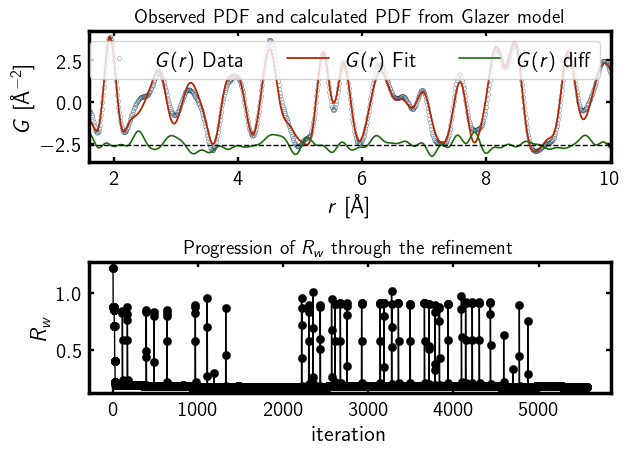

Dumped output_glazer/NdNiO3_GS_10_r_1.6-10_tempseries/NdNiO3_GS_10_r_1.6-10_tempseries_refined_params.yml
####################### Starting refinement for NdNiO3_GS_10_r_1.6-10_T_240 #######################
Optimizing scale...
Optimizing lattice parameter and Glazer tilts...
Optimizing A site displacements...
Optimizing Glazer tilts and A site displacements together...
Optimizing ADPs...
Optimizing scale, lattice parameter, Glazer tilts and A site displacements together...
... and adding in the ADPs...
Optimizing scale, lattice parameter and Glazer tilts once more...
Optimizing delta...
Optimizing all parameters together...
... done!

Dumped output_glazer/NdNiO3_GS_10_r_1.6-10_tempseries/fit/NdNiO3_GS_10_r_1.6-10_T_240.fit
Dumped output_glazer/NdNiO3_GS_10_r_1.6-10_tempseries/res/NdNiO3_GS_10_r_1.6-10_T_240.res
Dumped output_glazer/NdNiO3_GS_10_r_1.6-10_tempseries/stru//NdNiO3_GS_10_r_1.6-10_T_240.cif

Results from the Glazer fit:
Some quantities invalid due to missing profile uncertain

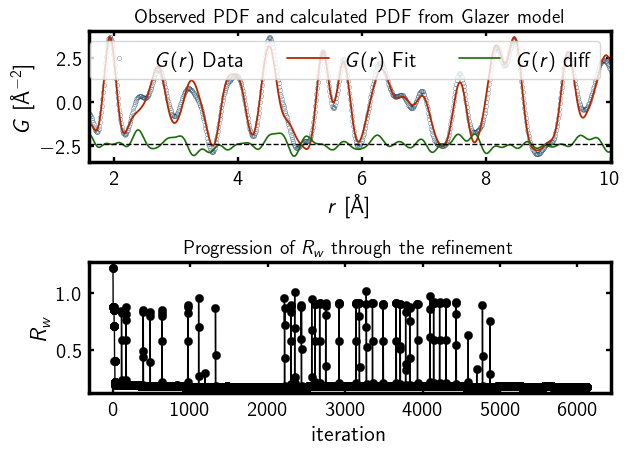

Dumped output_glazer/NdNiO3_GS_10_r_1.6-10_tempseries/NdNiO3_GS_10_r_1.6-10_tempseries_refined_params.yml
####################### Starting refinement for NdNiO3_GS_10_r_1.6-10_T_250 #######################
Optimizing scale...
Optimizing lattice parameter and Glazer tilts...
Optimizing A site displacements...
Optimizing Glazer tilts and A site displacements together...
Optimizing ADPs...
Optimizing scale, lattice parameter, Glazer tilts and A site displacements together...
... and adding in the ADPs...
Optimizing scale, lattice parameter and Glazer tilts once more...
Optimizing delta...
Optimizing all parameters together...
... done!

Dumped output_glazer/NdNiO3_GS_10_r_1.6-10_tempseries/fit/NdNiO3_GS_10_r_1.6-10_T_250.fit
Dumped output_glazer/NdNiO3_GS_10_r_1.6-10_tempseries/res/NdNiO3_GS_10_r_1.6-10_T_250.res
Dumped output_glazer/NdNiO3_GS_10_r_1.6-10_tempseries/stru//NdNiO3_GS_10_r_1.6-10_T_250.cif

Results from the Glazer fit:
Some quantities invalid due to missing profile uncertain

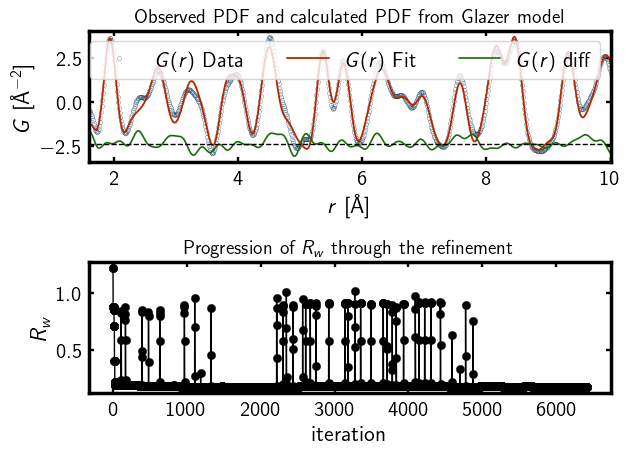

Dumped output_glazer/NdNiO3_GS_10_r_1.6-10_tempseries/NdNiO3_GS_10_r_1.6-10_tempseries_refined_params.yml
####################### Starting refinement for NdNiO3_GS_10_r_1.6-10_T_300 #######################
Optimizing scale...
Optimizing lattice parameter and Glazer tilts...
Optimizing A site displacements...
Optimizing Glazer tilts and A site displacements together...
Optimizing ADPs...
Optimizing scale, lattice parameter, Glazer tilts and A site displacements together...
... and adding in the ADPs...
Optimizing scale, lattice parameter and Glazer tilts once more...
Optimizing delta...
Optimizing all parameters together...
... done!

Dumped output_glazer/NdNiO3_GS_10_r_1.6-10_tempseries/fit/NdNiO3_GS_10_r_1.6-10_T_300.fit
Dumped output_glazer/NdNiO3_GS_10_r_1.6-10_tempseries/res/NdNiO3_GS_10_r_1.6-10_T_300.res
Dumped output_glazer/NdNiO3_GS_10_r_1.6-10_tempseries/stru//NdNiO3_GS_10_r_1.6-10_T_300.cif

Results from the Glazer fit:
Some quantities invalid due to missing profile uncertain

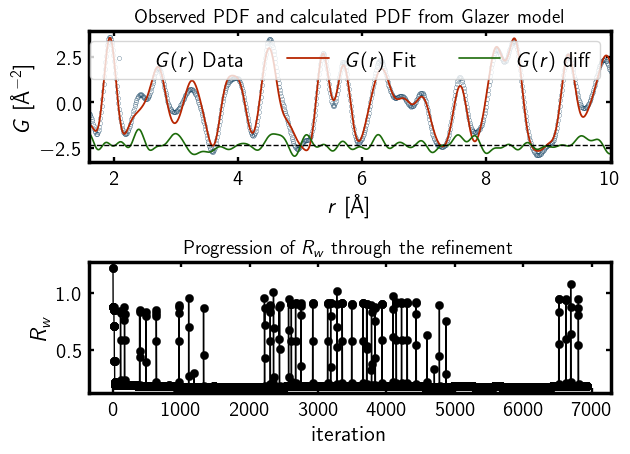

Dumped output_glazer/NdNiO3_GS_10_r_1.6-10_tempseries/NdNiO3_GS_10_r_1.6-10_tempseries_refined_params.yml


In [16]:
#### TEMPERATURE SERIES refinements ####
if __name__ == "__main__":
    gf.main_series()